<font color="#CC3D3D"><p>
# [Competition] Building a `DNN` Model with `Pipeline`

####  전역변수 설정

In [2]:
DNN_VERSION = 1.0  # submission 화일명에 사용
SEED = 0           # random_state 지정|

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random

import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
print(tf.__version__)

2.12.0


In [4]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(SEED)
    random.seed(SEED)
    tf.compat.v1.set_random_seed(SEED) # tf와 random,np randomseed 고정해줘야함(위의 3개)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU gpu를 쓰면 고정이 안됨. 필요X
    print("RANDOM SEEDS RESET")  # optional
   

reset_seeds()

RANDOM SEEDS RESET


In [5]:
#nn의 weight가 처음에는 임의의 값이 되므로 seed를 설정해주는 것이중요함!
#내가있는 어떤 정보가 내 취업에 어떤 영향을 미칠까? 라는 주제의 데이터인데 아마 쓰진 않을것임. 

#### (전처리된) 데이터 로딩

In [1]:
# 학습 데이터
X_train = pd.read_csv('X_train_preprocessed.csv').drop(columns='ID')
y_train = pd.read_csv('y_train.csv').Salary

# 평가 데이터
X_test = pd.read_csv('X_test_preprocessed.csv')
test_id = X_test.ID
X_test = X_test.drop(columns='custid')

NameError: name 'pd' is not defined

In [5]:
# 학습 데이터를 다시 학습과 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

<font color="blue"><p>
#### DNN 모형 생성

<font color="blue"><p>
- 1단계: 모형 정의하기 (입력층/은익층/출력층 쌓기)

In [10]:
X_train.shape[1] 
#처음에는 입력층 687개, 은닉층첫번째는 128개 , 두번째은닉층은 64개, 마지막 출력층 1개하면 결과값이 나옴. 
#(각각의 연결에 가중치 적용됨) 
#activate 입력층 빼고 activate함수인 relu함수를 내가정한것. 
# output의 최종값까지 지정하고 전체모형정의함. 

687

In [7]:
inputs = keras.Input(shape=X_train.shape[1], )          # 입력층
x = keras.layers.Dense(128, activation='relu')(inputs)  # 첫번째 은닉층(숫자는 neural값설정)
x = keras.layers.Dense(64, activation='relu')(x)        # 두번째 은닉층 (X값을 다음에서 넘겨받음 )
output = keras.layers.Dense(1, activation='linear')(x)  # 출력층

model = keras.Model(inputs=inputs, outputs=output)      # 입력층과 출력층을 지정함으로써 전체모형 정의

In [8]:
# 모형 구조 출력: Total params가 많을수록 복잡한 모델임. (만든 nn-model이 잘 만들어졌는지 확인 )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 687)]             0         
                                                                 
 dense (Dense)               (None, 128)               88064     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 96,385
Trainable params: 96,385
Non-trainable params: 0
_________________________________________________________________


In [12]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [13]:
# 연결 그래프 시각화: graphviz와 pydot 설치 필요 (graphviz 다운로드하고 설치한 후 pip install pydot)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
#여기까지 neural network를구성함 (network만 구성한 상태)
#이 밑에 부터 학습진행할것임 

<font color="blue"><p>
- 2단계: 학습방식(손실함수/옵티마이저/평가척도) 설정하기

In [ ]:
#어떤 loss function을쓸것이냐? 'mse'로지정 / model.compile이라는 method를 통해 정의. /optimzer는 종류가 많음 ( 경사하강법도 이중에하나)

In [15]:
model.compile(
    loss='mse',
    optimizer=keras.optimizers.RMSprop(),                     
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

In [22]:
#데이터갯수확인 
X_train.shape[0]

16570

<font color="blue"><p>
- 3단계: 모형 학습하기 (에포크, 배치사이즈, 조기중단 등 지정) 

In [16]:
hist = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid,y_valid), # DNN 학습시 검증데이터가 필요함 => 미리 학습과 검증 데이터로 나누었을 경우
#    validation_split=0.1,             # DNN 학습시 검증데이터가 필요함 => 미리 나누지 않을 경우
    batch_size=64, 
    epochs=200,    #X_train데이터 갯수를 64로 쪼갬. * 200번 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)], # 검증데이터의 Loss가 5회연속 감소하지 않으면 학습 중단.
    shuffle=False,       # 재현을 위해 False로 설정.
    verbose=2,
)

Epoch 1/200
259/259 - 2s - loss: 4338691.5000 - rmse: 2082.9526 - val_loss: 1548880.7500 - val_rmse: 1244.5404 - 2s/epoch - 9ms/step
Epoch 2/200
259/259 - 1s - loss: 912057.4375 - rmse: 955.0170 - val_loss: 869671.8125 - val_rmse: 932.5620 - 781ms/epoch - 3ms/step
Epoch 3/200
259/259 - 1s - loss: 767509.8125 - rmse: 876.0764 - val_loss: 807028.3125 - val_rmse: 898.3475 - 715ms/epoch - 3ms/step
Epoch 4/200
259/259 - 1s - loss: 736290.5000 - rmse: 858.0737 - val_loss: 785518.3125 - val_rmse: 886.2947 - 780ms/epoch - 3ms/step
Epoch 5/200
259/259 - 1s - loss: 721044.1250 - rmse: 849.1432 - val_loss: 773662.1875 - val_rmse: 879.5807 - 601ms/epoch - 2ms/step
Epoch 6/200
259/259 - 1s - loss: 711204.3750 - rmse: 843.3293 - val_loss: 765299.0000 - val_rmse: 874.8137 - 795ms/epoch - 3ms/step
Epoch 7/200
259/259 - 1s - loss: 703823.0625 - rmse: 838.9417 - val_loss: 758586.8125 - val_rmse: 870.9689 - 605ms/epoch - 2ms/step
Epoch 8/200
259/259 - 1s - loss: 697849.6875 - rmse: 835.3740 - val_loss: 7

Epoch 63/200
259/259 - 1s - loss: 472245.2188 - rmse: 687.2010 - val_loss: 486876.7812 - val_rmse: 697.7656 - 781ms/epoch - 3ms/step
Epoch 64/200
259/259 - 1s - loss: 468066.0625 - rmse: 684.1536 - val_loss: 482689.8125 - val_rmse: 694.7588 - 853ms/epoch - 3ms/step
Epoch 65/200
259/259 - 1s - loss: 463829.8750 - rmse: 681.0505 - val_loss: 478475.7812 - val_rmse: 691.7194 - 763ms/epoch - 3ms/step
Epoch 66/200
259/259 - 1s - loss: 459683.5312 - rmse: 677.9996 - val_loss: 474198.0938 - val_rmse: 688.6204 - 737ms/epoch - 3ms/step
Epoch 67/200
259/259 - 1s - loss: 455557.7188 - rmse: 674.9501 - val_loss: 470102.9375 - val_rmse: 685.6405 - 810ms/epoch - 3ms/step
Epoch 68/200
259/259 - 1s - loss: 451411.4688 - rmse: 671.8716 - val_loss: 465788.8438 - val_rmse: 682.4872 - 762ms/epoch - 3ms/step
Epoch 69/200
259/259 - 1s - loss: 447234.4688 - rmse: 668.7559 - val_loss: 462295.7188 - val_rmse: 679.9233 - 845ms/epoch - 3ms/step
Epoch 70/200
259/259 - 1s - loss: 443150.4062 - rmse: 665.6954 - val_

Epoch 125/200
259/259 - 1s - loss: 233295.3438 - rmse: 483.0066 - val_loss: 268964.6562 - val_rmse: 518.6180 - 826ms/epoch - 3ms/step
Epoch 126/200
259/259 - 1s - loss: 230453.6406 - rmse: 480.0559 - val_loss: 267230.2188 - val_rmse: 516.9432 - 718ms/epoch - 3ms/step
Epoch 127/200
259/259 - 1s - loss: 227751.9062 - rmse: 477.2336 - val_loss: 265896.8125 - val_rmse: 515.6519 - 802ms/epoch - 3ms/step
Epoch 128/200
259/259 - 1s - loss: 224992.8594 - rmse: 474.3341 - val_loss: 262168.8438 - val_rmse: 512.0242 - 825ms/epoch - 3ms/step
Epoch 129/200
259/259 - 1s - loss: 222338.7656 - rmse: 471.5281 - val_loss: 262429.8438 - val_rmse: 512.2791 - 914ms/epoch - 4ms/step
Epoch 130/200
259/259 - 1s - loss: 219766.5781 - rmse: 468.7927 - val_loss: 261148.4531 - val_rmse: 511.0269 - 883ms/epoch - 3ms/step
Epoch 131/200
259/259 - 1s - loss: 217209.2344 - rmse: 466.0571 - val_loss: 260158.9375 - val_rmse: 510.0578 - 928ms/epoch - 4ms/step
Epoch 132/200
259/259 - 1s - loss: 214651.5469 - rmse: 463.305

Epoch 187/200
259/259 - 1s - loss: 128561.0625 - rmse: 358.5541 - val_loss: 204106.4531 - val_rmse: 451.7814 - 757ms/epoch - 3ms/step
Epoch 188/200
259/259 - 1s - loss: 128105.3125 - rmse: 357.9180 - val_loss: 201229.7188 - val_rmse: 448.5864 - 892ms/epoch - 3ms/step
Epoch 189/200
259/259 - 1s - loss: 127153.0547 - rmse: 356.5853 - val_loss: 194838.1875 - val_rmse: 441.4048 - 919ms/epoch - 4ms/step
Epoch 190/200
259/259 - 1s - loss: 125979.3516 - rmse: 354.9357 - val_loss: 198328.7344 - val_rmse: 445.3412 - 822ms/epoch - 3ms/step
Epoch 191/200
259/259 - 1s - loss: 124367.8828 - rmse: 352.6583 - val_loss: 195432.0938 - val_rmse: 442.0770 - 827ms/epoch - 3ms/step
Epoch 192/200
259/259 - 1s - loss: 122975.6250 - rmse: 350.6788 - val_loss: 192909.0312 - val_rmse: 439.2141 - 824ms/epoch - 3ms/step
Epoch 193/200
259/259 - 1s - loss: 122737.1406 - rmse: 350.3386 - val_loss: 202130.4688 - val_rmse: 449.5892 - 792ms/epoch - 3ms/step
Epoch 194/200
259/259 - 1s - loss: 121298.7109 - rmse: 348.279

In [ ]:
#nn은 학습할때 중간중간에 확인해줘야함. 

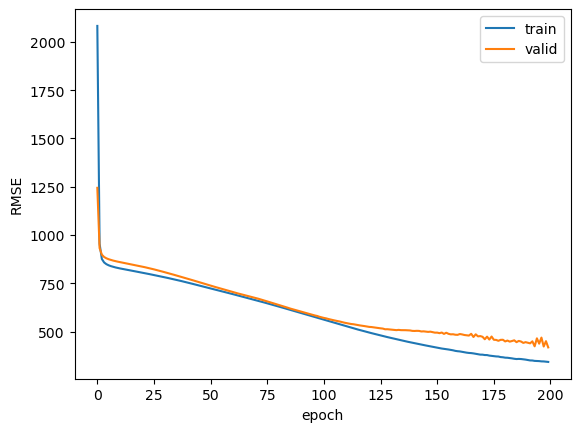

In [17]:
# 러닝커브 그리기: 학습이 잘되었는지 어느정도 판단할 수 있음.

plt.plot(hist.history['rmse'], label="train")
plt.plot(hist.history['val_rmse'], label="valid")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
#validation loss 를봐야함 . 
#그래프가 올라가는 형태의 underfitting이 발생하면 해결불가임.. 
#차라리 내려가는게 나음. 그러면 overfitting이니까 규제화를 해서 조금은 해결할수있음. 

In [18]:
results = model.evaluate(X_valid, y_valid)
print("valid loss, valid rmse:", results)

52/52 [==============================] - 0s 2ms/step - loss: 174825.7188 - rmse: 418.1216
valid loss, valid rmse: [174825.71875, 418.12164306640625]


<font color="blue"><p>
- 4단계: 예측하기

In [19]:
# 예측값 얻기: sklearn 과 달리 2차원 array로 출력 => 1차원으로 변경 필요.
pred = model.predict(X_test).flatten()

# # submission 화일 생성
# filename = f'dnn_{DNN_VERSION}_{hist.history["val_rmse"][-1]:.2f}.csv'
# pd.DataFrame({'ID':test_id, 'Salary':pred}).to_csv(filename, index=False)

# print(f'{filename} is ready to submit.')

346/346 [==============================] - 1s 1ms/step


In [27]:
pred.shape

(11048,)

In [ ]:
#nn은 artecture를 쌓는거부터 hyper parameter를 만드는 것과똑같음. 

#### 만들어진 submission 화일을 아래 사이트에서 Late Submission한 후 성능을 확인!
https://www.kaggle.com/competitions/kml2022f

<font color="#CC3D3D"><p>
# End